# 2048 DQN 모델 학습

## 학습 계획
- **목적**: 2048 게임에서 고득점을 달성하는 CNN 기반 DQN 에이전트 학습
- **아키텍처**: CNN (Layered)
- **환경**: Google Colab GPU 사용

## 환경 설정

In [ ]:
# 필요한 패키지 설치
!pip install torch torchvision gym matplotlib seaborn tensorboard
!pip install onnx onnxruntime

import torch
print(f"PyTorch 버전: {torch.__version__}")
print(f"CUDA 사용 가능: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")

## 코드 업로드 및 설정

In [2]:
# Google Drive 마운트
from google.colab import drive
drive.mount('/content/drive')

import sys
import os

# 프로젝트 경로 설정
PROJECT_ROOT = '/content/drive/MyDrive/2048-rl-project'
TRAINING_PATH = os.path.join(PROJECT_ROOT, 'training')

# Python 경로에 추가
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)
if TRAINING_PATH not in sys.path:
    sys.path.insert(0, TRAINING_PATH)

# 작업 디렉토리 변경
os.chdir(TRAINING_PATH)

print(f"✅ 경로 설정 완료!")
print(f"  프로젝트 루트: {PROJECT_ROOT}")
print(f"  학습 경로: {TRAINING_PATH}")
print(f"  현재 작업 디렉토리: {os.getcwd()}")

Mounted at /content/drive
✅ 경로 설정 완료!
  프로젝트 루트: /content/drive/MyDrive/2048-rl-project
  학습 경로: /content/drive/MyDrive/2048-rl-project/training
  현재 작업 디렉토리: /content/drive/MyDrive/2048-rl-project/training


## 모델 및 환경 불러오기

In [4]:
# 모듈 import 및 테스트
print("🔄 모듈 로딩 시작...")

from environment.game_2048 import Game2048Env
from models.dqn_agent import DQNAgent
from models.networks import count_parameters

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from IPython.display import clear_output
import pandas as pd

print("✅ 모듈 로드 완료")

🔄 모듈 로딩 시작...
✅ Models 패키지 로드 완료 - 지원 네트워크: ['layered']
✅ 모듈 로드 완료


## 학습 설정

In [5]:
# 학습 하이퍼파라미터
TRAINING_CONFIG = {
    # 기본 설정
    'episodes': 2000,
    'max_steps_per_episode': 1000,
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',

    # DQN 설정
    'buffer_size': 100000,
    'batch_size': 64,
    'lr': 1e-4,
    'gamma': 0.99,
    'epsilon_start': 1.0,
    'epsilon_end': 0.01,
    'epsilon_decay': 50000,
    'target_update': 1000,

    # 평가 설정
    'eval_interval': 100,
    'eval_episodes': 10,
    'save_interval': 500,

    # 시각화 설정
    'plot_interval': 50,
    'log_interval': 10
}

print("⚙️ 학습 설정 완료:")
for key, value in TRAINING_CONFIG.items():
    print(f"  {key}: {value}")

⚙️ 학습 설정 완료:
  episodes: 2000
  max_steps_per_episode: 1000
  device: cuda
  buffer_size: 100000
  batch_size: 64
  lr: 0.0001
  gamma: 0.99
  epsilon_start: 1.0
  epsilon_end: 0.01
  epsilon_decay: 50000
  target_update: 1000
  eval_interval: 100
  eval_episodes: 10
  save_interval: 500
  plot_interval: 50
  log_interval: 10


## 모델 초기화

In [7]:
def create_agent_and_env():
    """에이전트와 환경 생성"""
    env = Game2048Env()

    agent = DQNAgent(
        lr=TRAINING_CONFIG['lr'],
        gamma=TRAINING_CONFIG['gamma'],
        epsilon_start=TRAINING_CONFIG['epsilon_start'],
        epsilon_end=TRAINING_CONFIG['epsilon_end'],
        epsilon_decay=TRAINING_CONFIG['epsilon_decay'],
        buffer_size=TRAINING_CONFIG['buffer_size'],
        batch_size=TRAINING_CONFIG['batch_size'],
        target_update=TRAINING_CONFIG['target_update'],
        device=TRAINING_CONFIG['device']
    )

    return agent, env

print("🧠 CNN 에이전트 생성...")
agent, env = create_agent_and_env()
print(f"📊 모델 파라미터: {count_parameters(agent.q_network):,}")

🧠 CNN 에이전트 생성...
🤖 DQN Agent 초기화 - Device: cuda
   - 네트워크 파라미터: 1,628,805
   - 관찰 타입: layered (CNN)
   - Double DQN: True
   - Dueling DQN: True
   - 우선순위 재생: True
📊 모델 파라미터: 1,628,805


## 학습 모니터링 함수

In [8]:
class TrainingMonitor:
    def __init__(self):
        self.reset()

    def reset(self):
        self.episode_rewards = []
        self.episode_scores = []
        self.episode_steps = []
        self.episode_losses = []
        self.highest_tiles = []
        self.eval_scores = []
        self.eval_episodes = []

    def add_episode(self, reward, score, steps, loss, highest_tile):
        self.episode_rewards.append(reward)
        self.episode_scores.append(score)
        self.episode_steps.append(steps)
        self.episode_losses.append(loss)
        self.highest_tiles.append(highest_tile)

    def add_eval(self, episode, avg_score):
        self.eval_episodes.append(episode)
        self.eval_scores.append(avg_score)

    def plot_progress(self, title="Training Progress"):
        if len(self.episode_rewards) < 10:
            return

        fig, axes = plt.subplots(2, 3, figsize=(18, 12))
        fig.suptitle(title, fontsize=16)

        # 보상
        axes[0,0].plot(self.episode_rewards, alpha=0.3, color='blue')
        axes[0,0].plot(pd.Series(self.episode_rewards).rolling(50).mean(), color='red')
        axes[0,0].set_title('Episode Rewards')
        axes[0,0].set_ylabel('Reward')

        # 점수
        axes[0,1].plot(self.episode_scores, alpha=0.3, color='green')
        axes[0,1].plot(pd.Series(self.episode_scores).rolling(50).mean(), color='red')
        axes[0,1].set_title('Episode Scores')
        axes[0,1].set_ylabel('Score')

        # 최고 타일
        axes[0,2].plot(self.highest_tiles, alpha=0.3, color='purple')
        axes[0,2].plot(pd.Series(self.highest_tiles).rolling(50).mean(), color='red')
        axes[0,2].set_title('Highest Tiles')
        axes[0,2].set_ylabel('Tile Value')

        # 스텝 수
        axes[1,0].plot(self.episode_steps, alpha=0.3, color='orange')
        axes[1,0].plot(pd.Series(self.episode_steps).rolling(50).mean(), color='red')
        axes[1,0].set_title('Episode Steps')
        axes[1,0].set_ylabel('Steps')
        axes[1,0].set_xlabel('Episode')

        # 손실
        if self.episode_losses and any(loss is not None for loss in self.episode_losses):
            valid_losses = [l for l in self.episode_losses if l is not None]
            if valid_losses:
                axes[1,1].plot(valid_losses, alpha=0.3, color='red')
                axes[1,1].plot(pd.Series(valid_losses).rolling(20).mean(), color='darkred')
        axes[1,1].set_title('Training Loss')
        axes[1,1].set_ylabel('Loss')
        axes[1,1].set_xlabel('Episode')

        # 평가 점수
        if self.eval_scores:
            axes[1,2].plot(self.eval_episodes, self.eval_scores, 'o-', color='darkgreen')
        axes[1,2].set_title('Evaluation Scores')
        axes[1,2].set_ylabel('Avg Score')
        axes[1,2].set_xlabel('Episode')

        plt.tight_layout()
        plt.show()

    def get_stats(self):
        if not self.episode_scores:
            return {}

        recent_scores = self.episode_scores[-100:]
        recent_tiles = self.highest_tiles[-100:]

        return {
            'episodes': len(self.episode_scores),
            'avg_score': np.mean(recent_scores),
            'max_score': max(self.episode_scores),
            'avg_highest_tile': np.mean(recent_tiles),
            'max_highest_tile': max(self.highest_tiles),
            'avg_steps': np.mean(self.episode_steps[-100:])
        }

monitor = TrainingMonitor()
print("📊 학습 모니터링 시스템 준비 완료!")

📊 학습 모니터링 시스템 준비 완료!


## 학습 함수

In [9]:
def evaluate_agent(agent, env, num_episodes=5):
    """에이전트 평가 함수"""
    total_scores = []
    for _ in range(num_episodes):
        state = env.reset()
        steps = 0
        while steps < 1000:
            action = agent.select_action(state, training=False)
            next_state, _, done, info = env.step(action)
            state = next_state
            steps += 1
            if done:
                total_scores.append(info['score'])
                break
    return np.mean(total_scores) if total_scores else 0

def train_agent(agent, env, monitor, episodes):
    """에이전트 학습 함수"""
    print(f"🚀 CNN 모델 학습 시작! (목표: {episodes} 에피소드)")
    start_time = time.time()
    best_score = 0

    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        steps = 0
        episode_losses = []

        while steps < TRAINING_CONFIG['max_steps_per_episode']:
            action = agent.select_action(state, training=True)
            next_state, reward, done, info = env.step(action)
            agent.store_experience(state, action, reward, next_state, done)

            if len(agent.memory) >= agent.batch_size:
                loss = agent.train_step()
                if loss is not None:
                    episode_losses.append(loss)

            state = next_state
            total_reward += reward
            steps += 1
            if done:
                break

        avg_loss = np.mean(episode_losses) if episode_losses else None
        monitor.add_episode(total_reward, info['score'], steps, avg_loss, info['highest'])
        agent.episode_rewards.append(total_reward)

        if info['score'] > best_score:
            best_score = info['score']
            agent.save_model(f'/content/drive/MyDrive/2048_models/cnn_model_best.pth')

        if (episode + 1) % TRAINING_CONFIG['log_interval'] == 0:
            stats = agent.get_stats()
            elapsed = time.time() - start_time
            loss_str = f"{avg_loss:.3f}" if avg_loss is not None else "N/A"
            print(f"Episode {episode+1:4d} | Score: {info['score']:4.0f} | Reward: {total_reward:6.1f} | "
                  f"Steps: {steps:3d} | Epsilon: {stats['epsilon']:.3f} | Loss: {loss_str} | Time: {elapsed/60:.1f}min")

        if (episode + 1) % TRAINING_CONFIG['eval_interval'] == 0:
            eval_score = evaluate_agent(agent, env, TRAINING_CONFIG['eval_episodes'])
            monitor.add_eval(episode + 1, eval_score)
            print(f"🎯 Evaluation (Episode {episode+1}): {eval_score:.1f}")

        if (episode + 1) % TRAINING_CONFIG['plot_interval'] == 0:
            clear_output(wait=True)
            monitor.plot_progress(f"CNN Training Progress")
            stats = monitor.get_stats()
            print(f"📊 현재 통계:")
            for key, value in stats.items():
                print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

        if (episode + 1) % TRAINING_CONFIG['save_interval'] == 0:
            agent.save_model(f'/content/drive/MyDrive/2048_models/cnn_checkpoint_{episode+1}.pth')

    agent.save_model(f'/content/drive/MyDrive/2048_models/cnn_final.pth')
    print(f"✅ 학습 완료!")
    return monitor

print("🔧 학습 함수 로드 완료!")

🔧 학습 함수 로드 완료!


## CNN 모델 학습

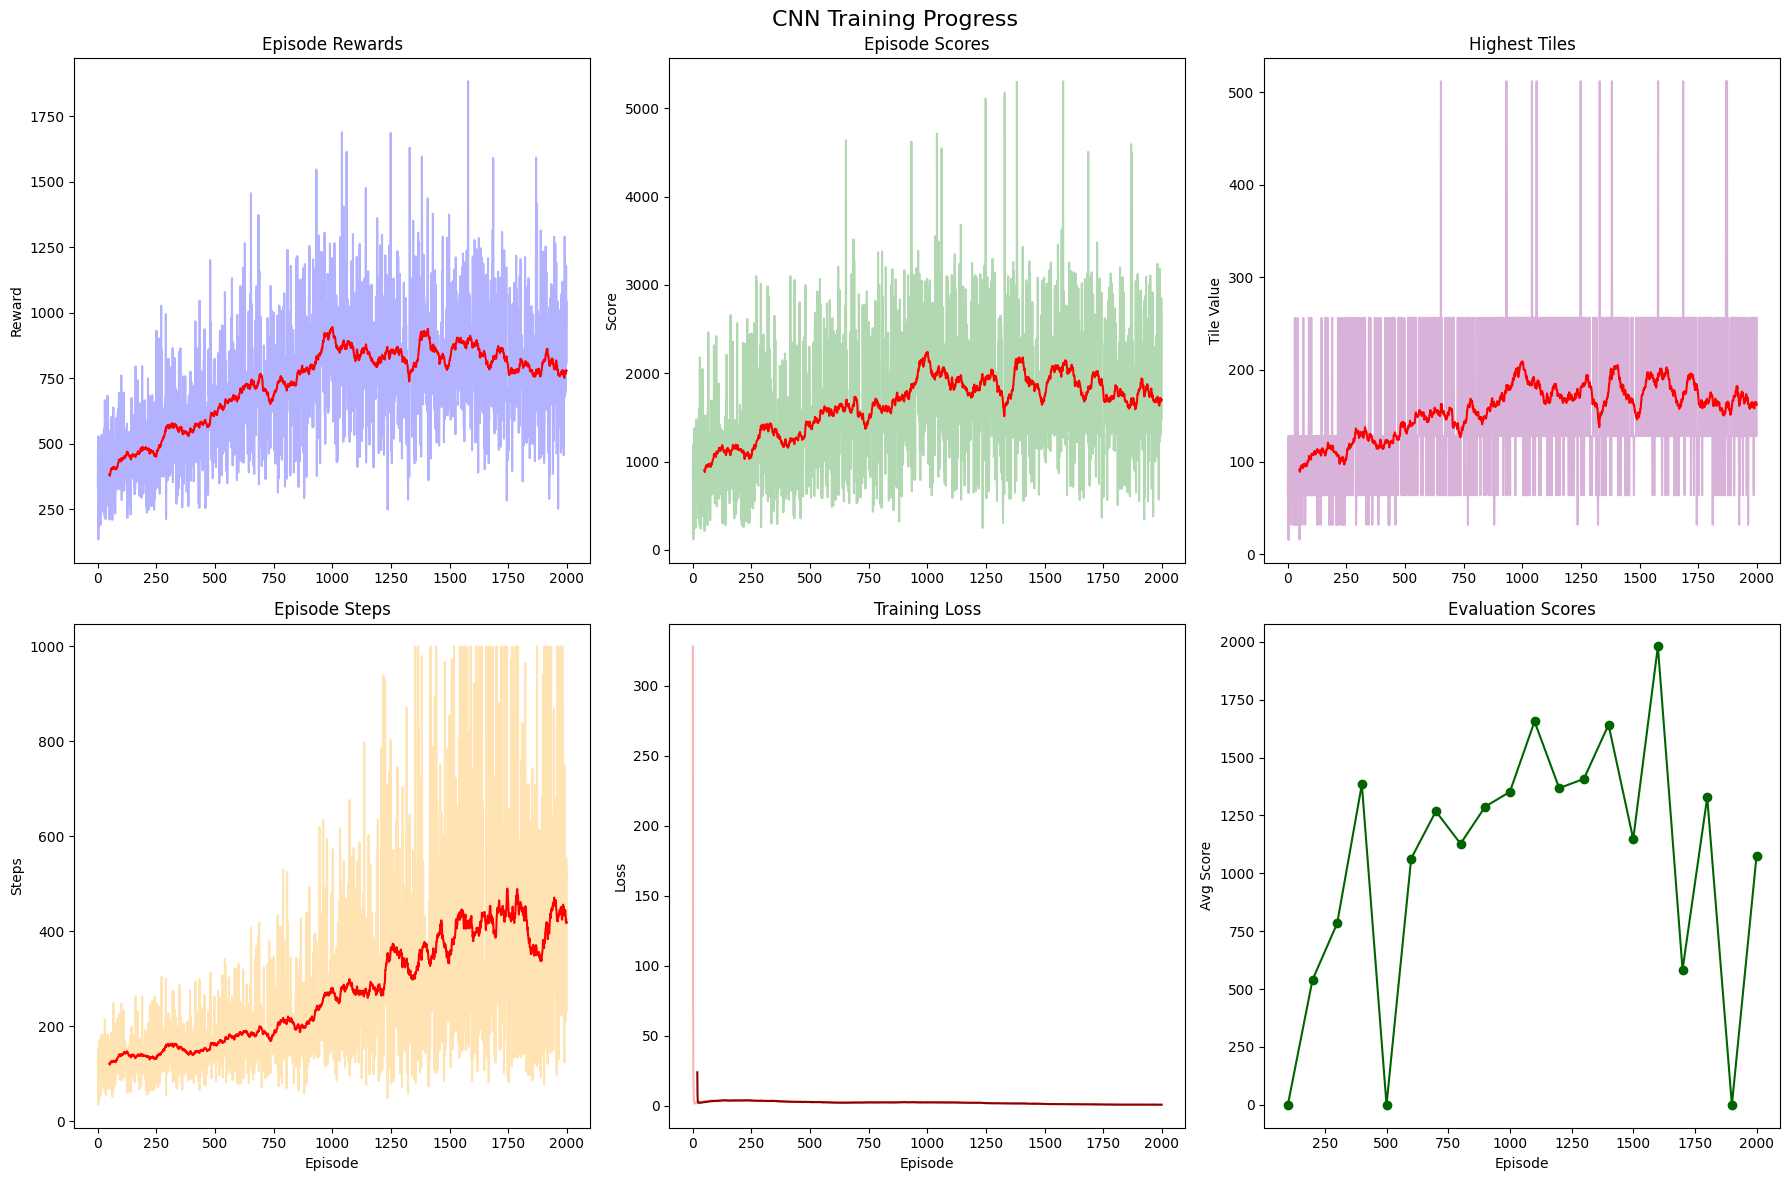

📊 현재 통계:
  episodes: 2000
  avg_score: 1720.84
  max_score: 5308
  avg_highest_tile: 163.84
  max_highest_tile: 512
  avg_steps: 438.40
💾 모델 저장 완료: /content/drive/MyDrive/2048_models/cnn_checkpoint_2000.pth
💾 모델 저장 완료: /content/drive/MyDrive/2048_models/cnn_final.pth
✅ 학습 완료!


In [10]:
monitor = train_agent(
    agent=agent,
    env=env,
    monitor=monitor,
    episodes=TRAINING_CONFIG['episodes']
)

## 🏆 최종 성능 평가

In [ ]:
print("🏆 최종 성능 평가 (50 게임)" )
final_score = evaluate_agent(agent, env, 50)
print(f"📊 최종 평균 점수: {final_score:.1f}")

stats = monitor.get_stats()
print("📈 최종 학습 통계:")
for key, value in stats.items():
    print(f"  {key}: {value:.2f}" if isinstance(value, float) else f"  {key}: {value}")

## ONNX 변환

In [13]:
print("🔄 ONNX 변환 시작...")
agent.export_to_onnx(
    filepath='/content/drive/MyDrive/2048_models/cnn_model.onnx',
    input_shape=(4, 4, 16)
)
print("✅ ONNX 변환 완료!")

🔄 ONNX 변환 시작...


/content/drive/MyDrive/2048-rl-project/training/models/networks.py:53: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if x.dim() == 4 and x.shape[-1] == 16:


🔄 ONNX 모델 내보내기 완료: /content/drive/MyDrive/2048_models/cnn_model.onnx
✅ ONNX 변환 완료!


## 데모 플레이

In [ ]:
def demo_play(agent, env, render_interval=10):
    print(f"🎮 데모 플레이 시작!")
    state = env.reset()
    done = False
    steps = 0
    while not done and steps < 1000:
        if steps % render_interval == 0:
            clear_output(wait=True)
            env.render()
            print(f"Step: {steps}")
            time.sleep(0.5)
        action = agent.select_action(state, training=False)
        state, _, done, info = env.step(action)
        steps += 1
    env.render()
    print(f"🏁 게임 종료!")
    print(f"  최종 점수: {info['score']}")
    print(f"  최고 타일: {info['highest']}")
    print(f"  총 스텝: {steps}")

demo_play(agent, env)

In [ ]:
## 🧪 고급 게임 테스트 및 기록

def advanced_game_test(agent, env, num_games=10, detailed_log=True):
    """
    Illegal move 처리와 함께 상세한 게임 테스트 및 기록
    """
    print(f"🧪 고급 게임 테스트 시작 ({num_games} 게임)")
    
    game_records = []
    illegal_move_stats = {
        'total_illegal_attempts': 0,
        'games_with_illegal_moves': 0,
        'illegal_moves_per_game': []
    }
    
    for game_idx in range(num_games):
        print(f"\n🎮 게임 {game_idx + 1}/{num_games} 시작...")
        
        state = env.reset()
        game_record = {
            'game_id': game_idx + 1,
            'moves': [],
            'states': [],
            'q_values': [],
            'illegal_attempts': 0,
            'final_score': 0,
            'highest_tile': 0,
            'total_steps': 0,
            'game_over_reason': ''
        }
        
        done = False
        steps = 0
        game_illegal_moves = 0
        
        while not done and steps < 2000:  # 최대 2000 스텝
            # 현재 상태 저장
            game_record['states'].append(state.copy())
            
            # 모든 액션에 대한 Q값 계산
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(agent.device)
                q_values = agent.q_network(state_tensor).cpu().numpy()[0]
                game_record['q_values'].append(q_values.copy())
            
            # Q값 순서대로 액션 시도 (높은 순서부터)
            action_order = np.argsort(q_values)[::-1]  # 내림차순 정렬
            
            action_taken = None
            attempts = 0
            
            for action in action_order:
                attempts += 1
                
                # 액션이 유효한지 확인
                if env.is_valid_move(action):
                    action_taken = action
                    break
                else:
                    # Illegal move 시도 기록
                    game_illegal_moves += 1
                    illegal_move_stats['total_illegal_attempts'] += 1
                    
                    if detailed_log and attempts == 1:  # 첫 번째 시도가 실패한 경우만 로그
                        print(f"  Step {steps}: Illegal move attempted (action={action}, Q={q_values[action]:.3f})")
            
            if action_taken is None:
                # 모든 액션이 불가능한 경우 (게임 오버)
                game_record['game_over_reason'] = 'no_valid_moves'
                done = True
                break
            
            # 액션 실행
            next_state, reward, done, info = env.step(action_taken)
            
            # 이동 기록
            game_record['moves'].append({
                'step': steps,
                'action': int(action_taken),
                'action_name': ['UP', 'DOWN', 'LEFT', 'RIGHT'][action_taken],
                'q_value': float(q_values[action_taken]),
                'reward': float(reward),
                'illegal_attempts_this_step': attempts - 1
            })
            
            state = next_state
            steps += 1
            
            if done:
                game_record['game_over_reason'] = 'board_full' if not env.is_valid_move_available() else 'max_steps'
        
        # 게임 종료 정보 기록
        game_record['final_score'] = info['score']
        game_record['highest_tile'] = info['highest']
        game_record['total_steps'] = steps
        game_record['illegal_attempts'] = game_illegal_moves
        
        illegal_move_stats['illegal_moves_per_game'].append(game_illegal_moves)
        if game_illegal_moves > 0:
            illegal_move_stats['games_with_illegal_moves'] += 1
        
        game_records.append(game_record)
        
        print(f"  ✅ 게임 {game_idx + 1} 완료: 점수={info['score']}, 최고타일={info['highest']}, "
              f"스텝={steps}, 불법시도={game_illegal_moves}")
    
    return game_records, illegal_move_stats

def analyze_game_records(game_records, illegal_move_stats):
    """게임 기록 분석 및 시각화"""
    print("\n📊 게임 테스트 결과 분석")
    print("=" * 50)
    
    # 기본 통계
    scores = [record['final_score'] for record in game_records]
    highest_tiles = [record['highest_tile'] for record in game_records]
    steps = [record['total_steps'] for record in game_records]
    
    print(f"🎯 기본 통계:")
    print(f"  평균 점수: {np.mean(scores):.1f} (±{np.std(scores):.1f})")
    print(f"  최고 점수: {max(scores)}")
    print(f"  평균 최고 타일: {np.mean(highest_tiles):.1f}")
    print(f"  최고 타일 분포: {dict(zip(*np.unique(highest_tiles, return_counts=True)))}")
    print(f"  평균 게임 길이: {np.mean(steps):.1f} 스텝")
    
    # Illegal move 통계
    print(f"\n🚫 Illegal Move 분석:")
    print(f"  총 불법 시도: {illegal_move_stats['total_illegal_attempts']}")
    print(f"  불법 시도가 있던 게임: {illegal_move_stats['games_with_illegal_moves']}/{len(game_records)}")
    if illegal_move_stats['illegal_moves_per_game']:
        print(f"  게임당 평균 불법 시도: {np.mean(illegal_move_stats['illegal_moves_per_game']):.2f}")
    
    # 액션 분포 분석
    all_actions = []
    for record in game_records:
        all_actions.extend([move['action'] for move in record['moves']])
    
    action_counts = np.bincount(all_actions, minlength=4)
    action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
    
    print(f"\n🎯 액션 분포:")
    for i, (name, count) in enumerate(zip(action_names, action_counts)):
        percentage = count / len(all_actions) * 100
        print(f"  {name}: {count} ({percentage:.1f}%)")
    
    # 시각화
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # 점수 분포
    axes[0,0].hist(scores, bins=20, alpha=0.7, color='blue')
    axes[0,0].axvline(np.mean(scores), color='red', linestyle='--', label=f'Mean: {np.mean(scores):.1f}')
    axes[0,0].set_title('Score Distribution')
    axes[0,0].set_xlabel('Score')
    axes[0,0].set_ylabel('Frequency')
    axes[0,0].legend()
    
    # 최고 타일 분포
    unique_tiles, counts = np.unique(highest_tiles, return_counts=True)
    axes[0,1].bar(range(len(unique_tiles)), counts, alpha=0.7, color='green')
    axes[0,1].set_title('Highest Tile Distribution')
    axes[0,1].set_xlabel('Highest Tile Value')
    axes[0,1].set_ylabel('Frequency')
    axes[0,1].set_xticks(range(len(unique_tiles)))
    axes[0,1].set_xticklabels(unique_tiles)
    
    # 액션 분포
    axes[1,0].bar(action_names, action_counts, alpha=0.7, color='orange')
    axes[1,0].set_title('Action Distribution')
    axes[1,0].set_xlabel('Action')
    axes[1,0].set_ylabel('Count')
    
    # 게임 길이 vs 점수
    axes[1,1].scatter(steps, scores, alpha=0.6, color='purple')
    axes[1,1].set_title('Game Length vs Score')
    axes[1,1].set_xlabel('Steps')
    axes[1,1].set_ylabel('Score')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'avg_score': np.mean(scores),
        'max_score': max(scores),
        'avg_highest_tile': np.mean(highest_tiles),
        'avg_steps': np.mean(steps),
        'illegal_move_rate': illegal_move_stats['total_illegal_attempts'] / sum(steps) if sum(steps) > 0 else 0
    }

def save_game_records(game_records, filepath='/content/drive/MyDrive/2048_models/game_test_records.json'):
    """게임 기록을 JSON 파일로 저장"""
    import json
    
    # NumPy 배열을 리스트로 변환
    serializable_records = []
    for record in game_records:
        serializable_record = record.copy()
        serializable_record['states'] = [state.tolist() for state in record['states']]
        serializable_record['q_values'] = [q_val.tolist() for q_val in record['q_values']]
        serializable_records.append(serializable_record)
    
    with open(filepath, 'w') as f:
        json.dump(serializable_records, f, indent=2)
    
    print(f"💾 게임 기록이 저장되었습니다: {filepath}")

print("🧪 고급 테스트 함수들이 로드되었습니다!")

In [ ]:
## 🎮 실제 게임 테스트 실행

# DQNAgent에 is_valid_move 메서드가 없을 수 있으므로 환경에 추가
if not hasattr(env, 'is_valid_move'):
    def is_valid_move(self, action):
        """액션이 유효한지 확인"""
        old_board = self.board.copy()
        if action == 0:  # UP
            new_board = self._move_up(old_board.copy())
        elif action == 1:  # DOWN
            new_board = self._move_down(old_board.copy())
        elif action == 2:  # LEFT
            new_board = self._move_left(old_board.copy())
        elif action == 3:  # RIGHT
            new_board = self._move_right(old_board.copy())
        
        return not np.array_equal(old_board, new_board)
    
    # 메서드를 환경에 동적으로 추가
    env.is_valid_move = is_valid_move.__get__(env, env.__class__)

def is_valid_move_available(env):
    """사용 가능한 액션이 있는지 확인"""
    for action in range(4):
        if env.is_valid_move(action):
            return True
    return False

# 환경에 메서드 추가
env.is_valid_move_available = lambda: is_valid_move_available(env)

print("🔧 환경 확장 완료!")

# 실제 테스트 실행
print("🚀 고급 게임 테스트 시작!")
game_records, illegal_stats = advanced_game_test(
    agent=agent, 
    env=env, 
    num_games=20,  # 20게임 테스트
    detailed_log=True
)

# 결과 분석
test_results = analyze_game_records(game_records, illegal_stats)

# 기록 저장
save_game_records(game_records)

print("\n🏆 테스트 요약:")
print(f"  평균 점수: {test_results['avg_score']:.1f}")
print(f"  최고 점수: {test_results['max_score']}")
print(f"  평균 최고 타일: {test_results['avg_highest_tile']:.1f}")
print(f"  불법 이동 비율: {test_results['illegal_move_rate']*100:.2f}%")

In [ ]:
## 🎬 게임 플레이 시각화

def visualize_game_play(game_record, step_interval=5):
    """특정 게임의 플레이를 단계별로 시각화"""
    print(f"🎬 게임 {game_record['game_id']} 플레이 시각화")
    print(f"최종 점수: {game_record['final_score']}, 최고 타일: {game_record['highest_tile']}")
    
    states = game_record['states']
    moves = game_record['moves']
    q_values = game_record['q_values']
    
    for i in range(0, len(states), step_interval):
        if i < len(moves):
            move = moves[i]
            print(f"\n--- Step {i} ---")
            print(f"Action: {move['action_name']} (Q-value: {move['q_value']:.3f})")
            print(f"Reward: {move['reward']:.1f}")
            if move['illegal_attempts_this_step'] > 0:
                print(f"⚠️  Illegal attempts: {move['illegal_attempts_this_step']}")
            
            # Q-values 출력
            q_vals = q_values[i]
            action_names = ['UP', 'DOWN', 'LEFT', 'RIGHT']
            print("Q-values:", end=" ")
            for j, (name, q_val) in enumerate(zip(action_names, q_vals)):
                marker = "🎯" if j == move['action'] else ""
                print(f"{name}:{q_val:.3f}{marker}", end=" ")
            print()
            
            # 보드 상태 출력 (간단한 형태)
            board = states[i].argmax(axis=2)  # 가장 높은 값의 인덱스
            board_values = 2 ** board
            board_values[board == 0] = 0
            
            print("Board:")
            for row in board_values:
                print("  " + " ".join(f"{val:4d}" for val in row))
        
        time.sleep(0.5)  # 시각화 속도 조절

# 가장 높은 점수를 받은 게임 찾기
best_game = max(game_records, key=lambda x: x['final_score'])
print(f"🏆 최고 점수 게임 (게임 {best_game['game_id']}): {best_game['final_score']}점")

# 최고 점수 게임 시각화 (선택적)
# visualize_game_play(best_game, step_interval=10)